# Imports

In [1]:
import gym
import math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

# Create the environment

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env = gym.make('MountainCar-v0')

print('observation space:', env.observation_space)
print('action space:', env.action_space)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
observation space: Box(2,)
action space: Box(1,)


# Run one episode

In [3]:
class Agent(nn.Module):
    def __init__(self, env, h_size=16):
        # Function to initialize the environment using neural networks 
        super(Agent, self).__init__()
        self.env = env
        # Calculate the state, hidden layer and action sizes
        self.s_size = env.observation_space.shape[0]
        self.h_size = h_size
        self.a_size = env.action_space.shape[0]
        # Define layers in the neural network
        self.fc1 = nn.Linear(self.s_size, self.h_size)
        self.fc2 = nn.Linear(self.h_size, self.a_size)
        
    def set_weights(self, weights):
        # Function to calculate the weights of the layers 
        s_size = self.s_size
        h_size = self.h_size
        a_size = self.a_size
        # Calculate the weights for each layer
        fc1_end = (s_size*h_size)+h_size
        fc1_W = torch.from_numpy(weights[:s_size*h_size].reshape(s_size, h_size))
        fc1_b = torch.from_numpy(weights[s_size*h_size:fc1_end])
        fc2_W = torch.from_numpy(weights[fc1_end:fc1_end+(h_size*a_size)].reshape(h_size, a_size))
        fc2_b = torch.from_numpy(weights[fc1_end+(h_size*a_size):])
        # Set the weights for each layer
        self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
        self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))
    
    def get_weights_dim(self):
        return (self.s_size+1)*self.h_size + (self.h_size+1)*self.a_size
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x.cpu().data
        
    def evaluate(self, weights, gamma=1.0, max_steps=5000):
        # Function to evaluate the rewards
        self.set_weights(weights)
        episode_return = 0.0
        state = self.env.reset()
        # For every step in an episode, calculate the state, action and reward
        for t in range(max_steps):
            state = torch.from_numpy(state).float().to(device)
            action = self.forward(state)
            state, reward, done, _ = self.env.step(action)
            episode_return += reward * math.pow(gamma, t)
            if done:
                break
        return episode_return
    
agent = Agent(env).to(device)

# Train the agent

In [4]:
def train_till_success(num_episodes=500, max_steps=1000, gamma=1.0, size=50, noise=0.5):
    # num_episodes is maximum number of episodes
    # max_steps is the maximum number of steps for each episode
    # gamma is the discount rate
    # size is the maximum size of population for each episode
    # top_frac is the percentage of top performing episodes to use to train
    # noise is the standard deviation of additive noise
          
    n_top=int(size*0.2) # 0.2: Considering that we use only top 2% of the winning episodes to train

    scores_dq = deque(maxlen=100)  # Create a double ended queue of length 100
    scores = [] # Create an array to store the rewards per episode
    # Calculate the best weight as the product of noise and random weight generated by agent.get_weights_dim()
    best_weight = noise*np.random.randn(agent.get_weights_dim())
    
    # For every episode, calculate the weight and rewards
    for i_iteration in range(1, num_episodes+1):
        weights_pop = [best_weight + (noise*np.random.randn(agent.get_weights_dim())) for x in range(size)]
        rewards = np.array([agent.evaluate(weights, gamma, max_steps) for weights in weights_pop])
        
        # Calculate the top 2% rewards
        top_idxs = rewards.argsort()[-n_top:]
        # Calculate the top 2% weights
        top_weights = [weights_pop[i] for i in top_idxs]
        # Assign the mean value of top 2% weights to best_weight
        best_weight = np.array(top_weights).mean(axis=0)
        
        # Evaluate the reward for the agent with the best_weight and discount rate gamma
        reward = agent.evaluate(best_weight, gamma=1.0)
        scores_dq.append(reward)    # Append the reward to the double ended queue scores_dq
        scores.append(reward)   # Append the rewards to the array scores
        
        torch.save(agent.state_dict(), 'checkpoint.pth')    # Save the current state of the agent
        
        # Calculate and print the average score for every for every 10 episodes
        if i_iteration % 10 == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_dq)))
        
        # Print the mean score for all the episodes
        if np.mean(scores_dq)>=90.0:
            print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(i_iteration-100, np.mean(scores_dq)))
            break
    return scores   # Return the scores

scores = train_till_success()


C:\Users\Chandu\Desktop\UCF\Sem 1\AAI\OpenAI_FinalAss\venv\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 10	Average Score: -4.05
Episode 20	Average Score: -12.36
Episode 30	Average Score: -8.15
Episode 40	Average Score: 5.97
Episode 50	Average Score: 23.34
Episode 60	Average Score: 35.35
Episode 70	Average Score: 43.78
Episode 80	Average Score: 50.04
Episode 90	Average Score: 54.86
Episode 100	Average Score: 58.63
Episode 110	Average Score: 68.42
Episode 120	Average Score: 79.83
Episode 130	Average Score: 89.17

Environment solved in 31 iterations!	Average Score: 90.48


# Plot the graph of scores

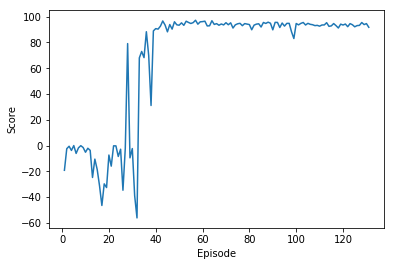

In [5]:
# Plot the scores in a graph using the matplotlib object plt
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()
env.close()